# Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/MyDrive/ANDL/Homework_2

/gdrive/MyDrive/ANDL/Homework_2


# Libraries

In [ ]:
!pip install 

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

ModuleNotFoundError: ignored

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load Data

In [ ]:
X_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

X_train.shape, y_train.shape

In [ ]:
df = pd.DataFrame()

for t in range(0, 2429):
  temp_df = pd.DataFrame(X_train[t, :, :])
  temp_df["serie"] = t
  temp_df["target"] = y_train[t]
  df = pd.concat([df, temp_df])
df = df.rename(columns={0:"x0", 1:"x1", 2:"x2", 3:"x3", 4:"x4", 5:"x5"})
print(df)

In [ ]:
df.head(1000)

In [ ]:
window = 36
stride = 36

In [ ]:
def build_sequences(df, window=36, stride=36):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for s in df['serie'].unique():
        # Take only meaningful features
        temp = df[df['serie'] == s][['x0', 'x1', 'x2', 'x3', 'x4', 'x5']].values
        # Save the label
        label = df[df['serie'] == s]['target'].values[0]
        # Compute padding length
        #padding_len = window - len(temp)%window
        # Create padding and concatenate it
        #padding = np.zeros((padding_len,6), dtype='float64')
        #temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
X_train, y_train = build_sequences(df, window, stride)
X_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train ,random_state=104, test_size=0.15, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2064, 36, 6), (2064,), (365, 36, 6), (365,))

In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2064, 36, 6), (2064, 12), (365, 36, 6), (365, 12))

In [ ]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)

    attention = SeqSelfAttention(attention_activation='sigmoid')(bilstm)

    lstm = tfkl.GlobalAveragePooling1D()(attention)

    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 36, 256)          394240    
 nal)                                                            
                                                                 
 seq_self_attention_4 (SeqSe  (None, 36, 256)          16449     
 lfAttention)                                                    
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                      

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
15/15 [==============================] - 19s 628ms/step - loss: 1.9310 - accuracy: 0.3904 - val_loss: 1.7166 - val_accuracy: 0.4155 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 8s 513ms/step - loss: 1.4818 - accuracy: 0.4997 - val_loss: 1.3745 - val_accuracy: 0.4928 - lr: 0.0010
Epoch 3/200
15/15 [==============================] - 8s 513ms/step - loss: 1.2304 - accuracy: 0.5773 - val_loss: 1.1822 - val_accuracy: 0.5797 - lr: 0.0010
Epoch 4/200
15/15 [==============================] - 8s 513ms/step - loss: 1.0627 - accuracy: 0.6370 - val_loss: 1.1039 - val_accuracy: 0.6232 - lr: 0.0010
Epoch 5/200
15/15 [==============================] - 8s 513ms/step - loss: 0.9590 - accuracy: 0.6742 - val_loss: 1.0990 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 6/200
15/15 [==============================] - 8s 511ms/step - loss: 0.8277 - accuracy: 0.7237 - val_loss: 1.1057 - val_accuracy: 0.6377 - lr: 0.0010
Epoch 7/200
15/15 [==============================] - 8s 512ms/s

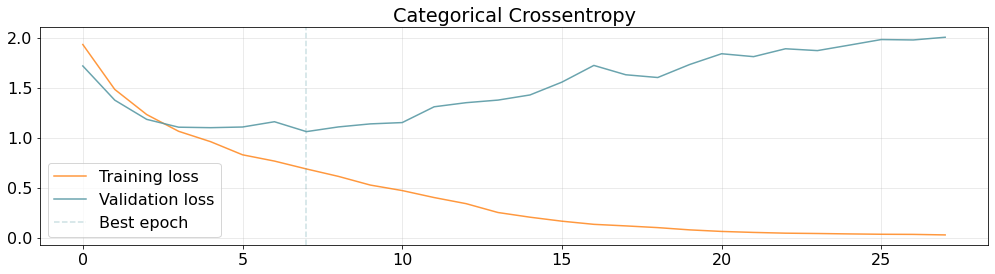

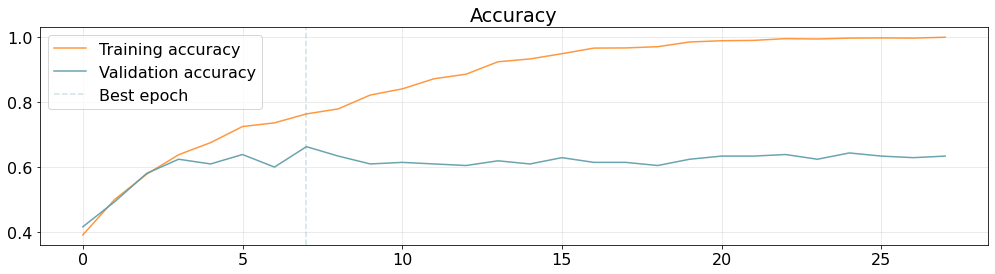

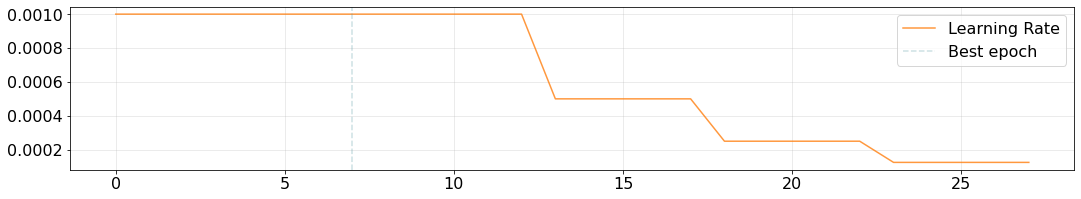

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('new_df/BiLSTM/new_df_attention_no_norm')
# model = tfk.models.load_model('BiLSTM')

In [ ]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

12/12 [==============================] - 2s 75ms/step


(365, 12)

Accuracy: 0.6356
Precision: 0.5318
Recall: 0.5686
F1: 0.5267


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


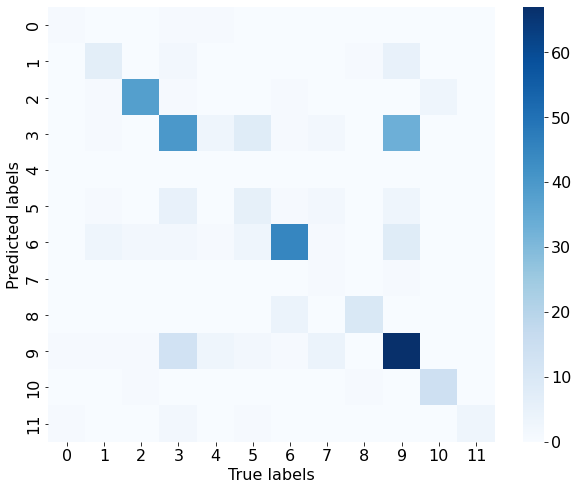

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()